# Wifi-sniffing Attack

*Jeff Qiu*  
*Jun 3, 2020*

## 0. Preperation

The file structure in our testing environment looks like this: 

```
.
├── community_ondevice
│   ├── HTTP Parsed
│   └── TLS Parsed
├── community_sniffer
├── local_ondevice
│   ├── Day1
│   ├── Day2
│   └── Day3
├── model.ipynb
└── writeup.md
```
In the following chunk, we import the necessary modules.

In [1]:
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

## 1. Import Data

In the following chunk, we extract training and testing data from cvs files. For on-device data, day 1 and 2 are used as training set, while day 3 is used as testing set. We will be testing sniffer data with model trained with day 1&2 of community on-device data. 

In [2]:
# community ondevice
community_ondevice_train_paths = [
    'community_ondevice/HTTP Parsed/day_1_parsed.csv',
    'community_ondevice/HTTP Parsed/day_2_parsed.csv',
    'community_ondevice/TLS Parsed/day_1_parsedTLS.csv',
    'community_ondevice/TLS Parsed/day_2_parsedTLS.csv',
] 
community_ondevice_test_paths = [
    'community_ondevice/HTTP Parsed/day_3_parsed.csv',
    'community_ondevice/TLS Parsed/day_3_parsedTLS.csv'
]

# local ondevice
local_ondevice_train_paths = ["local_ondevice/Day1/"+p for p in os.listdir('local_ondevice/Day1')] + \
    ["local_ondevice/Day2/"+p for p in os.listdir('local_ondevice/Day2')]
local_ondevice_test_paths = ["local_ondevice/Day3/"+p for p in os.listdir('local_ondevice/Day3')]

# community sniffer
community_sniffer_test_paths = ["community_sniffer/" + p for p in os.listdir('community_sniffer')]

def aggregate_to_df(list_of_paths):
    columns = ["website index", "time", "direction", "packet size"]
    list_of_dfs = []
    for p in tqdm(list_of_paths):
        df = pd.read_csv(p, header=0, names=columns)
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs, ignore_index=True, axis=0)

community_sniffer_test_df = aggregate_to_df(community_sniffer_test_paths)
local_ondevice_train_df = aggregate_to_df(local_ondevice_train_paths)
local_ondevice_test_df = aggregate_to_df(local_ondevice_test_paths)
community_ondevice_train_df = aggregate_to_df(community_ondevice_train_paths)
community_ondevice_test_df = aggregate_to_df(community_ondevice_test_paths)

100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


## 2. Preprocessing

Proprocessing consist of three parts. First, we add a `time_zeroed` column that contains the time difference between the current packet and the last packet received. If current packet is the first packet in the sequence, we leave the time as 0. Second, we normalize the `time` and `packet size` column by using min-max normalization. For `packet size`, we also use the log function to amplify the difference between similar values. Finally, we pack the normalized data into training and testing data. 

In [75]:
LIMIT = None

def preprocessing(df, limit=None):
    # zero base by subsequent packet
    df['time_shifted'] = df['time'].shift(fill_value=0)
    df['time_zeroed'] = (df['time']-df['time_shifted']).where(df['time']!=0)
    df = df.drop(columns=['time_shifted'])
    df = df.fillna(0)
    
    # log normalize data
    df['packet_normal'] = np.log(df['packet size'])
    df['time_normal'] = np.sqrt(df['time'])
    df = df.replace([np.inf, -np.inf], 0)
    packet_min = df['packet_normal'].min()
    packet_minmax = df['packet_normal'].max()-df['packet_normal'].min()
    time_min = df['time_normal'].min()
    time_minmax = df['time_normal'].max()-df['time_normal'].min()
    df['packet_normal'] = (df['packet_normal'] - packet_min) / packet_minmax
    df['time_normal'] = (df['time_normal'] - time_min) / time_minmax

    
    X = df[['packet_normal','time_normal']]
    y = df['website index']
    if not limit:
        return X, y, df
    else: 
        return X[:limit], y[:limit], df

X1_train, y1_train, train1 = preprocessing(community_ondevice_train_df, LIMIT)
X1_test, y1_test, test1 = preprocessing(community_ondevice_test_df, LIMIT)
X2_train, y2_train, train2 = preprocessing(local_ondevice_train_df, LIMIT)
X2_test, y2_test, test2 = preprocessing(local_ondevice_test_df, LIMIT)
X3_test, y3_test, test3 = preprocessing(community_sniffer_test_df, LIMIT)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1578d0b50>,
      dtype=object)

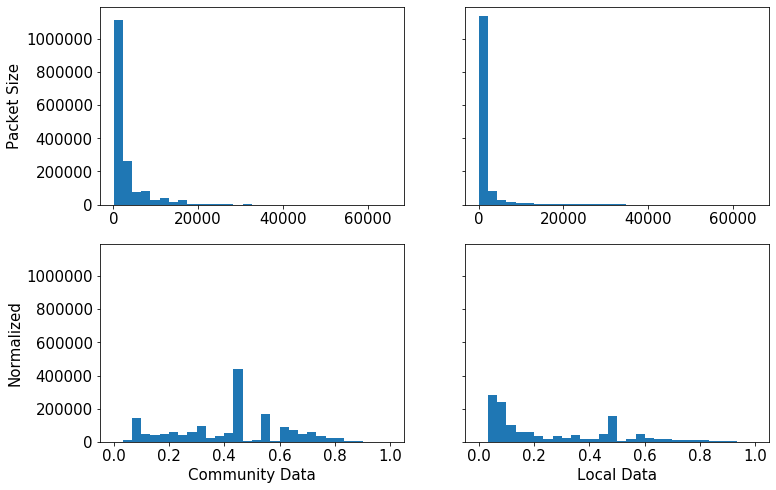

In [51]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(2, 2, sharey=True)
axs[0,0].hist(community_ondevice_train_df['packet size'], bins=30)
axs[0,1].hist(local_ondevice_train_df['packet size'], bins=30)
axs[1,0].hist(X1_train['packet_normal'], bins=30)
axs[1,1].hist(X2_train['packet_normal'], bins=30)
axs[0,0].set_ylabel('Packet Size')
axs[1,0].set_ylabel('Normalized')
axs[1,0].set_xlabel('Community Data')
axs[1,1].set_xlabel('Local Data')
axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15d418850>,
      dtype=object)

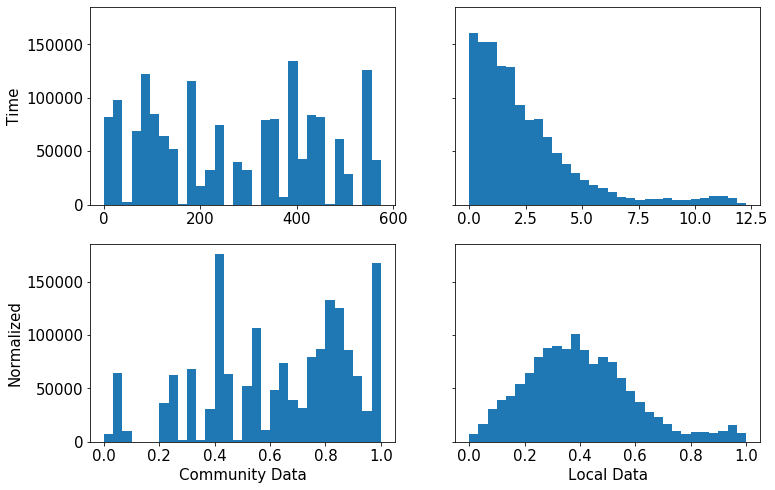

In [52]:
fig, axs = plt.subplots(2, 2, sharey=True)
axs[0,0].hist(community_ondevice_train_df['time'], bins=30)
axs[0,1].hist(local_ondevice_train_df['time'], bins=30)
axs[1,0].hist(X1_train['time_normal'], bins=30)
axs[1,1].hist(X2_train['time_normal'], bins=30)
axs[0,0].set_ylabel('Time')
axs[1,0].set_ylabel('Normalized')
axs[1,0].set_xlabel('Community Data')
axs[1,1].set_xlabel('Local Data')
axs

Text(0.5, 0.98, 'Normalized Time Distribution by Website, Local On-device')

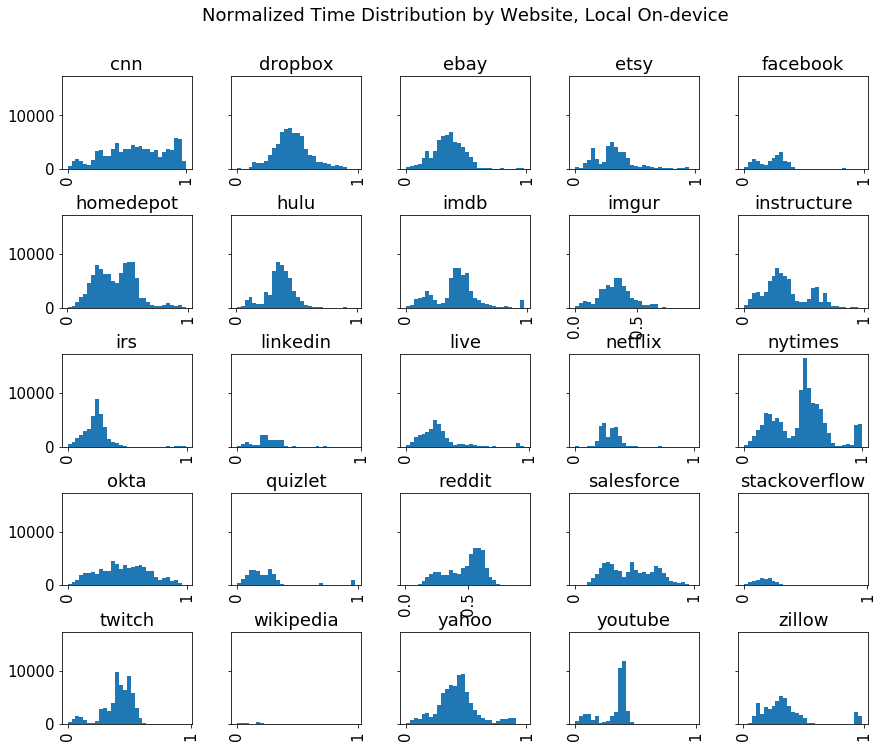

In [122]:
plt.rcParams['figure.figsize'] = (14.0, 12.0)
train2.hist(column='time_normal',sharey=True, by='website index', bins=30)
plt.suptitle("Normalized Time Distribution by Website, Local On-device")
# plt.subplots_adjust(hspace = 0.8)

## 3. Training Model

The model we use for training data is K-nearest Neighbor classifier. For each data point, we calculate the Euclidian distance between itself and all other data points, then classifies as the most frequent classification among $K$ points that are cloest to the data point. In the following chunk, we train a classifier using training data and return the trained model for testing.

In [24]:
def train(X_train, y_train, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, leaf_size=30)
    knn.fit(X_train, y_train)
    return knn

print('Training m1...', flush=True)
%time m1 = train(X1_train, y1_train)
print('Training m2...', flush=True)
%time m2 = train(X2_train, y2_train)

Training m1...
CPU times: user 48.6 s, sys: 266 ms, total: 48.9 s
Wall time: 48.8 s
Training m2...
CPU times: user 8.32 s, sys: 32.4 ms, total: 8.35 s
Wall time: 8.34 s


## 4. Testing

In the following chunk, we test the testing set against the model we trained previously, then report the overall accuracy and the accuracy breakdown by websites.

In [25]:
def test(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    results = pd.DataFrame({'label': y_test, 'prediction':y_pred})
    results['correct'] = results['label']==results['prediction']
    accuracy_by_website = results.groupby('label').sum()['correct']/results.groupby('label').count()['correct']*100

    print("Accuracy by website:")
    print(accuracy_by_website)
    
print('\nTesting community_ondevice...', flush=True)
test(m1, X1_test, y1_test)
print('\nTesting local_ondevice...', flush=True)
test(m2, X2_test, y2_test)
print('\nTesting community_sniffer using community model...', flush=True)
test(m1, X3_test, y3_test)
print('\nTesting community_sniffer using local model...', flush=True)
test(m2, X3_test, y3_test)


Testing community_ondevice...
Accuracy: 0.999993289986647
Accuracy by website:
label
cnn              100.000000
dropbox          100.000000
ebay             100.000000
facebook         100.000000
imdb             100.000000
imgur            100.000000
instructure      100.000000
irs              100.000000
linkedin         100.000000
live              99.994144
netflix          100.000000
nytimes          100.000000
okta             100.000000
reddit           100.000000
salesforce       100.000000
stackoverflow     99.995105
twitch           100.000000
wikipedia         99.979214
yahoo            100.000000
youtube          100.000000
Name: correct, dtype: float64

Testing local_ondevice...
Accuracy: 0.19712966543089136
Accuracy by website:
label
cnn              34.332724
dropbox          21.477769
ebay             15.295318
etsy             10.017917
facebook         22.445019
homedepot        30.572870
hulu             11.061006
imdb             13.388100
imgur            13.3021

3518